# DOE data analysis example

*Updated 8/25/24*

We start by loading all the required packages.

In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import pandas as pd
import itertools
import math
from scipy.stats import t
import statsmodels.api as sm

In [2]:
def linear_mapping(vector,old_range,new_range):
  """
  Args:
    vector: input vector, one dimensional array or single value
    old_range:[old_min old_max]
    new_range: [new_min new_max]
  Returns: scaled vector

  """
  scaled_vector = np.zeros_like(vector)
  for i in range(len(vector)):
        scaled_value = (vector[i] - old_range[0]) / (old_range[1] - old_range[0]) * (new_range[1] - new_range[0]) + new_range[0]
        scaled_vector[i] = scaled_value
  return scaled_vector


In [3]:
def find_ranges(arr):
  """
  find the min and max of each column of the array
  Args:
    arr:
 Returns: min and max of each column of the array
  """
  col_nm=arr.shape[1]
  ranges=np.zeros((col_nm,2))
  for i in range(col_nm):
    ranges[i,0]=arr[:,i].min()
    ranges[i,1]=arr[:,i].max()
  return ranges

In [4]:
def map_raw_to_coded_factors(arr,old_range):
 #map raw data to [-1  1]
  new_range=np.array([-1,1])
  mapped_arr=np.zeros_like(arr)
  factor_num=arr.shape[1]
  #factor_ranges=[[-1,1]]*factor_num
  #print(factor_ranges)
  for i in range(factor_num):
    vector=arr[:,i]
    mapped_arr[:,i]=linear_mapping(vector,old_range[i],new_range)
  mapped_arr=mapped_arr.astype(float)
  return mapped_arr

map the raw data of the main effects to [-1 0 1}

In [5]:
def compute_interaction_terms(X, interactions):
    X_interaction = np.zeros((X.shape[0], len(interactions)))
    for idx, interaction in enumerate(interactions):
        #print(idx)
        X_interaction[:, idx] = X[:, factors.index(interaction[0])] * X[:, factors.index(interaction[1])]
        #print(X_interaction)
    return X_interaction


The DOE data analysis starts with loading data of 2 level 3 factor full factrial design of catapult experiments from GitHub

In [6]:
url='https://raw.githubusercontent.com/yanwu2001/DOE-ML-Public/main/PhysicalCatapult/DOE_23FF_Group1.csv'
df=pd.read_csv(url)
print(df.head())
print(df.info())
print(df.describe())
#
l=list(df.columns)
arr=df.to_numpy()
factors=l[2:5]
print("factors in data set are", factors)
print("response in data set is", l[5])
combo=arr[:,1]
#print(combo)


     ID  Combo#     A     B     C      y
0  Run1       0  61.3  18.0  41.8  178.6
1  Run2       8  94.1  23.0  43.0  147.8
2  Run3       3  22.9  23.0  40.6  146.5
3  Run4       1  22.9  13.0  40.6  233.7
4  Run5       2  22.9  13.0  43.0  275.4
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28 entries, 0 to 27
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ID      28 non-null     object 
 1   Combo#  28 non-null     int64  
 2   A       28 non-null     float64
 3   B       28 non-null     float64
 4   C       28 non-null     float64
 5   y       28 non-null     float64
dtypes: float64(4), int64(1), object(1)
memory usage: 1.4+ KB
None
          Combo#          A          B          C           y
count  28.000000  28.000000  28.000000  28.000000   28.000000
mean    3.857143  58.900000  18.000000  41.800000  189.746429
std     2.690371  33.578829   4.714045   1.131371   45.049277
min     0.000000  22.900000  13.000000  4

In [7]:
#splitting data into base runs and center point runs
arr_base=[]
arr_center=[]
for i in range(len(combo)):
  if combo[i]==0:
    arr_center.append(arr[i,:])
  else:
    arr_base.append(arr[i,:])
arr_base=np.array(arr_base)
arr_center=np.array(arr_center)
#print(arr_base)
#print(arr_center)
print ('The shape of arr_base is: ' + str(arr_base.shape))
print ('The shape of arr_center is: ' + str(arr_center.shape))
print ('The shape of arr_base is: ' + str(arr_base.shape))
print ('The shape of arr_center is: ' + str(arr_center.shape))

The shape of arr_base is: (24, 6)
The shape of arr_center is: (4, 6)
The shape of arr_base is: (24, 6)
The shape of arr_center is: (4, 6)


In [8]:
# calculate effects: main effects and interaction
X_base=arr_base[:,2:5]
y_base=arr_base[:,5]
ranges=find_ranges(X_base)
X_mapped=map_raw_to_coded_factors(X_base,ranges)
#print(X_mapped)
interactions = list(itertools.combinations(factors, 2))
X_mapped_interaction=compute_interaction_terms(X_mapped, interactions)
#print(X_mapped_interaction)
X_effects=np.column_stack((X_mapped,X_mapped_interaction))
print(X_effects)

[[ 1.  1.  1.  1.  1.  1.]
 [-1.  1. -1. -1.  1. -1.]
 [-1. -1. -1.  1.  1.  1.]
 [-1. -1.  1.  1. -1. -1.]
 [-1.  1.  1. -1. -1.  1.]
 [ 1.  1. -1.  1. -1. -1.]
 [ 1. -1.  1. -1.  1. -1.]
 [ 1. -1. -1. -1. -1.  1.]
 [-1. -1. -1.  1.  1.  1.]
 [-1.  1.  1. -1. -1.  1.]
 [-1.  1. -1. -1.  1. -1.]
 [ 1. -1.  1. -1.  1. -1.]
 [ 1.  1.  1.  1.  1.  1.]
 [-1. -1.  1.  1. -1. -1.]
 [ 1. -1. -1. -1. -1.  1.]
 [ 1.  1. -1.  1. -1. -1.]
 [-1. -1.  1.  1. -1. -1.]
 [-1.  1. -1. -1.  1. -1.]
 [ 1. -1.  1. -1.  1. -1.]
 [ 1.  1.  1.  1.  1.  1.]
 [ 1. -1. -1. -1. -1.  1.]
 [-1.  1.  1. -1. -1.  1.]
 [ 1.  1. -1.  1. -1. -1.]
 [-1. -1. -1.  1.  1.  1.]]


In [9]:
# create DOE model
X_effects=sm.add_constant(X_effects)
#print(X_effects)
y_base = y_base.astype(float)
#print(y_base)
model = sm.OLS(y_base, X_effects).fit()
param_names = ['y_ave'] + factors + [f'{i[0]}:{i[1]}' for i in interactions]
print(model.summary(xname=param_names))
print(model.params)
#print(model.pvalues)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.972
Model:                            OLS   Adj. R-squared:                  0.962
Method:                 Least Squares   F-statistic:                     97.57
Date:                Mon, 26 Aug 2024   Prob (F-statistic):           3.20e-12
Time:                        16:12:21   Log-Likelihood:                -83.927
No. Observations:                  24   AIC:                             181.9
Df Residuals:                      17   BIC:                             190.1
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
y_ave        191.4083      1.938     98.788      0.0

In [10]:
#make prediction using raw data
x_test_raw=[[68.5, 21.5, 41.2],
            [22.9, 21.1, 43]]
x_test_scaled=map_raw_to_coded_factors(np.array(x_test_raw),ranges)
print(x_test_scaled)
x_test_interaction=compute_interaction_terms(x_test_scaled,interactions)
x_test=np.column_stack((x_test_scaled,x_test_interaction))
x_test=sm.add_constant(x_test)
#print(x_test)
y_pred=model.predict(x_test)
print(y_pred)

[[ 0.28089888  0.7        -0.5       ]
 [-1.          0.62        1.        ]]
[153.09216292 187.71833333]


['*14.44', '*41.85', '*14.21', '3.18', '1.39', '*4.88']


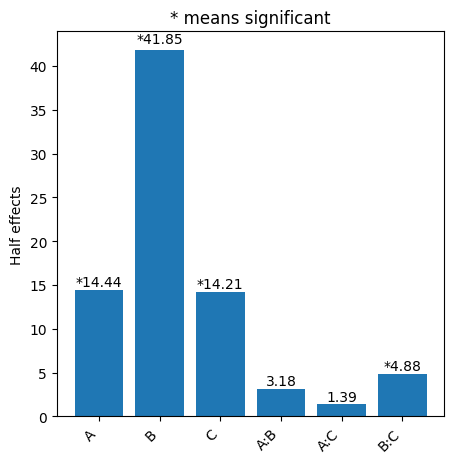

In [11]:
#visualize half effects
fig,ax=plt.subplots(figsize=(5,5))
x_txt=param_names[1:]
y_value=abs(model.params[1:])
y_p=model.pvalues[1:]
#print(y_p)
s_str=['{:.2f}'.format(i) for i in y_value]
for i in range(len(s_str)):
  if (y_p[i]<0.05):
    s_str[i]='*'+s_str[i]
print(s_str)
ax.bar(x_txt,y_value)
for i in range(len(y_value)):
  ax.text(x_txt[i],y_value[i]*1.01,s_str[i],ha='center',va='bottom')
ax.set_ylabel('Half effects')
ax.set_title('* means significant')
plt.xticks(rotation=45, ha="right")
plt.show()


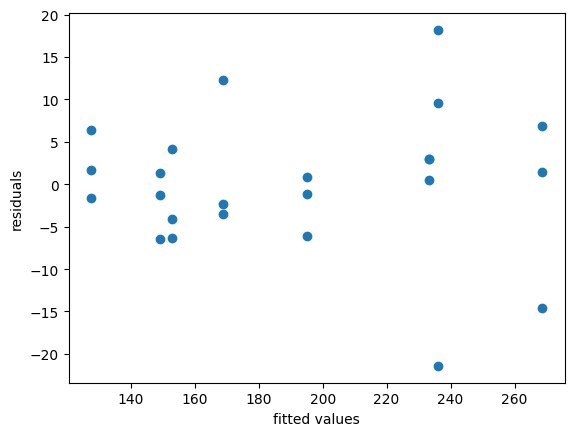

In [12]:
#check residuals
x_plot=model.fittedvalues
y_plot=model.resid
plt.scatter(x_plot,y_plot)
plt.xlabel('fitted values')
plt.ylabel('residuals')
plt.show()

In [13]:
#calculate parameters for center point runs and base runs
#this is a preparation for linearity test
X_center=arr_center[:,2:5]
y_center=arr_center[:,5]
std_err_half_effects=model.bse[0]
std_err_full_effects=2*std_err_half_effects
num_base=len(y_base)
num_center=len(y_center)
std_base=(math.sqrt(num_base)/2)*std_err_full_effects
dof_base=model.df_resid-1
print(dof_base)
print(std_base)
std_center=np.std(y_center,ddof=1)
dof_center=num_center-1
print(dof_center)
print(std_center)
pooled_std=math.sqrt((dof_base*std_base**2+dof_center*std_center**2)/(dof_base+dof_center))
print(pooled_std)
E_nonlinear=abs(np.mean(y_center)-np.mean(y_base))
print(E_nonlinear)
std_nonlinear=pooled_std*math.sqrt(1/num_base+1/num_center)
print(std_nonlinear)
t_nonlinear=E_nonlinear/std_nonlinear
print(t_nonlinear)



16.0
9.492101980067433
3
4.1804106656324285
8.867526504938654
11.633333333333326
4.7890116595638625
2.4291720631126585


In [14]:
#linearity test
alpha = 0.05  # Two-tailed test (1 - confidence level)
critical_t = t.ppf(1 - alpha / 2, (dof_base + dof_center))
print(critical_t)
DL=critical_t*std_nonlinear
print(DL)
if (E_nonlinear>DL):
  print("The system is non_linear")
else:
  print("The system is linear")

2.093024054408263
10.023516600308799
The system is non_linear
